# Gradient-TD (TDC) on the Seven-State Example

This notebook focuses on a gradient-based temporal-difference algorithm
often called TDC or GTD(0). We compare its behaviour on the same
seven-state off-policy setup used in the previous notebook.

The main goals here are to:
- Reuse the same MDP and feature representation.
- Implement the TDC update with a secondary weight vector.
- Observe how the error behaves and compare it qualitatively to
  semi-gradient TD(0).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os

# change working directory to the folder where your notebooks are
os.chdir("/Users/antonstepanyan/Desktop/RL/Reinforcement-Learning/counter-examples")  # <--- your real path here

# make sure the folder exists
os.makedirs("generated_images", exist_ok=True)

print("Current working directory:", os.getcwd())
print("Folders:", os.listdir())

rng = np.random.default_rng(1)

states = np.arange(0, 7)
lower_state = 6

discount = 0.99
feature_vector_size = 8

features = np.zeros((len(states), feature_vector_size))

for i in range(len(states) - 1):
    features[i, i] = 2.0
    features[i, feature_vector_size - 1] = 1.0

features[lower_state, feature_vector_size - 2] = 1.0
features[lower_state, feature_vector_size - 1] = 2.0

actions = {"dashed": 0, "solid": 1}

reward = 0.0

behavior_solid_probability = 1.0 / 7.0

state_distribution = np.ones(len(states)) / len(states)
state_distribution_matrix = np.diag(state_distribution)

projection_matrix = (
    features
    @ np.linalg.pinv(features.T @ state_distribution_matrix @ features)
    @ features.T
    @ state_distribution_matrix
)

def step(state, action):
    if action == actions["solid"]:
        return lower_state
    return rng.choice(states[:lower_state])

def behavior_policy(state):
    if rng.binomial(n=1, p=behavior_solid_probability) == 1:
        return actions["solid"]
    return actions["dashed"]

def compute_RMSVE(weights):
    approx_values = features @ weights
    squared_errors = approx_values ** 2
    ms_ve = np.dot(squared_errors, state_distribution)
    return np.sqrt(ms_ve)

def compute_RMSPBE(weights):
    bellman_errors = np.zeros(len(states))

    for s in states:
        for next_state in states:
            if next_state == lower_state:
                bellman_errors[s] += (
                    reward
                    + discount * np.dot(weights, features[next_state, :])
                    - np.dot(weights, features[s, :])
                )

    projected_be = projection_matrix @ bellman_errors
    squared_errors = projected_be ** 2
    ms_pbe = np.dot(squared_errors, state_distribution)
    return np.sqrt(ms_pbe)

def TDC_update(state, w, v, step_size_w, step_size_v):
    'One TDC (GTD(0)) update from a sampled transition.'
    action = behavior_policy(state)
    next_state = step(state, action)

    if action == actions["dashed"]:
        rho = 0.0
    else:
        rho = 1.0 / behavior_solid_probability

    phi_s = features[state, :]
    phi_next = features[next_state, :]

    td_error = (
        reward
        + discount * np.dot(phi_next, w)
        - np.dot(phi_s, w)
    )

    w += step_size_w * rho * (
        td_error * phi_s - discount * phi_next * np.dot(phi_s, v)
    )

    v += step_size_v * rho * (td_error - np.dot(phi_s, v)) * phi_s

    return next_state, w, v

Current working directory: /Users/antonstepanyan/Desktop/RL/Reinforcement-Learning/counter-examples
Folders: ['.DS_Store', 'generated_images', 'README.md', '.git', 'notebooks', '.idea', 'src']


## Running TDC

Below we simulate a long run of TDC on the the seven-state example and track
how the error measures evolve. The aim is not to produce a perfect
hyperparameter study, but to give a concrete picture of how this gradient
method behaves compared to simpler TD updates.

In [2]:
num_steps = 50_000
step_size_w = 0.05
step_size_v = 0.005

current_state = 0

w = np.zeros(feature_vector_size)
v = np.zeros(feature_vector_size)

rmsve_history = []
rmspbe_history = []

for t in range(num_steps):
    current_state, w, v = TDC_update(current_state, w, v, step_size_w, step_size_v)

    if (t + 1) % 100 == 0:
        rmsve_history.append(compute_RMSVE(w))
        rmspbe_history.append(compute_RMSPBE(w))

print("Final RMSVE:", rmsve_history[-1])
print("Final RMSPBE:", rmspbe_history[-1])

Final RMSVE: 0.0
Final RMSPBE: 0.0


Length check -> iters: 500 RMSVE: 500 RMSPBE: 500


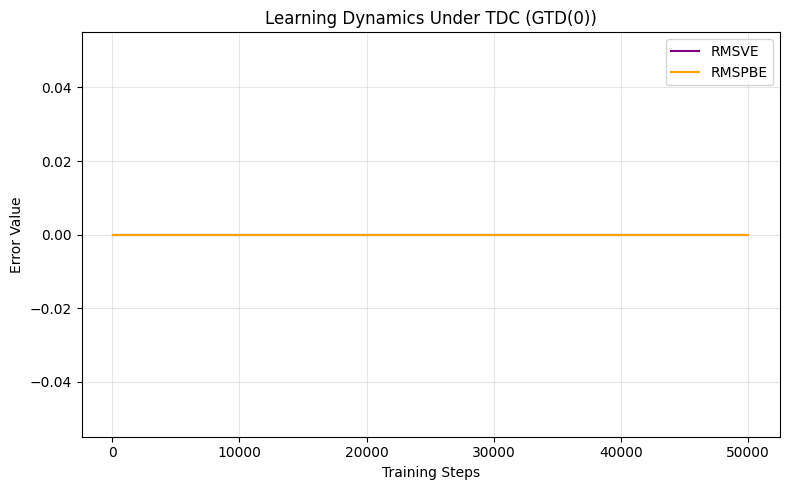

In [3]:
# Create the iteration index for TDC plots
iters = np.arange(100, num_steps + 1, 100)

# Verify lengths to avoid blank plots
print("Length check ->",
      "iters:", len(iters),
      "RMSVE:", len(rmsve_history),
      "RMSPBE:", len(rmspbe_history))

# Ensure output folder exists
import os
os.makedirs("generated_images", exist_ok=True)

# -------------------------------------
# TDC: RMSVE & RMSPBE Error Trajectories
# -------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(iters, rmsve_history, label="RMSVE", color="purple")
plt.plot(iters, rmspbe_history, label="RMSPBE", color="orange")
plt.xlabel("Training Steps")
plt.ylabel("Error Value")
plt.title("Learning Dynamics Under TDC (GTD(0))")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("generated_images/tdc_error_curves.png", dpi=300, bbox_inches='tight')
plt.show()


### Observations

In this configuration, TDC tends to maintain more stable error curves
compared to plain off-policy TD(0). The details depend on the chosen
step-sizes, but the key takeaway is that gradient-TD methods are designed
to address the divergence issues that can arise in off-policy training.